In [1]:
import json
import matplotlib.pyplot as plt

import bluepyopt as bpopt
import bluepyopt.ephys as ephys

import model
import evaluator
import time

import sys

from pathlib import Path

In [2]:
!rm -rf x86_64
!nrnivmodl mechanisms

which: no xcrun in (/gpfs/bbp.cscs.ch/home/mandge/lfpenv/bin:/gpfs/bbp.cscs.ch/ssd/apps/hpc/jenkins/deploy/externals/2021-01-06/linux-rhel7-x86_64/gcc-9.3.0/hpe-mpi-2.22.hmpt-r52ypu/bin:/gpfs/bbp.cscs.ch/ssd/apps/hpc/jenkins/deploy/externals/2021-01-06/linux-rhel7-x86_64/gcc-9.3.0/python-3.8.3-suxrst/bin:/gpfs/bbp.cscs.ch/apps/rhscl/rh-nodejs10/root/usr/bin:/gpfs/bbp.cscs.ch/ssd/apps/tools/jupyter/venvs/python37/bin:/opt/clmgr/sbin:/opt/clmgr/bin:/opt/sgi/sbin:/opt/sgi/bin:/usr/lib64/qt-3.3/bin:/gpfs/bbp.cscs.ch/home/mandge//.nix-profile/bin:/nix/var/nix/profiles/default/bin:/usr/lib64/ccache:/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/gpfs/bbp.cscs.ch/ssd/apps/bb5/systemtools:/opt/c3/bin:/opt/ibutils/bin:/opt/ddn/ime/bin:/sbin:/bin:/gpfs/bbp.cscs.ch/home/mandge/.local/bin:/gpfs/bbp.cscs.ch/home/mandge/bin)
/gpfs/bbp.cscs.ch/home/mandge/lfpy/multimodalfitting/models
Mod files: "mechanisms/cad.mod" "mechanisms/CaDynamics_DC0.mod" "mechanisms/CaDynamics_E2.mod" "mechanisms/Ca

In [3]:
probe = None #model.define_electrode(probe_type="linear")
model_name = 'hallermann' # "hay" 
morph_modifier = 'hallermann' # ""

In [4]:
cell = model.create(model=model_name, morph_modifier=morph_modifier, release=True)

param_names = [param.name for param in cell.params.values() if not param.frozen]

fitness_protocols = evaluator.define_protocols(
    model_name,
    feature_set="multiple",
    feature_file="hallermann_model/features_list.json",
    electrode=probe,
    protocols_with_lfp=None
)

fitness_calculator = ephys.objectivescalculators.ObjectivesCalculator([])
if model_name == 'hallermann':
    sim = ephys.simulators.LFPySimulator(cell, cvode_active=False, electrode=probe)
else:
    sim = ephys.simulators.LFPySimulator(cell, cvode_active=True, electrode=probe)
    
eva = ephys.evaluators.CellEvaluator(                    
        cell_model=cell,                                                       
        param_names=param_names,                                                    
        fitness_protocols=fitness_protocols,                                        
        fitness_calculator=fitness_calculator,                                      
        sim=sim)

In [5]:
fitness_protocols

{'Step1': <bluepyopt.ephys.protocols.SweepProtocol at 0x2acb467be7f0>}

In [6]:
t_start = time.time()
responses = eva.run_protocols(protocols=fitness_protocols.values(), param_values={})
print(f"Elapsed time: {time.time() - t_start}")

Elapsed time: 69.40045619010925


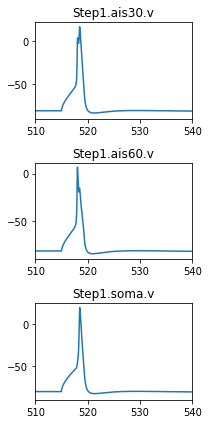

In [7]:
fig, axes = plt.subplots(len(responses), figsize=(3, 6), squeeze=False)
for index, (resp_name, response) in enumerate(sorted(responses.items())):
    axes[index, 0].plot(response['time'], response['voltage'], label=resp_name)
    axes[index, 0].set_title(resp_name)
    axes[index, 0].set_xlim([510,540])
fig.tight_layout()
fig.show()

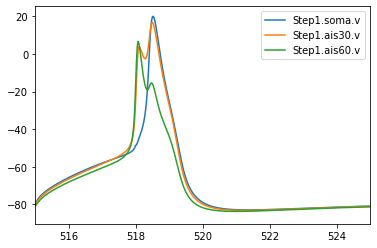

In [8]:
for index, (resp_name, response) in enumerate(responses.items()):
    if 'soma_' not in resp_name:
        plt.plot(response['time'], response['voltage'], label=resp_name)
    
plt.legend()    
plt.xlim([515,525])
plt.show()

In [9]:
max_dict = {}
max_index = {}

for index, (resp_name, response) in enumerate(responses.items()):
    max_dict[resp_name] =  max(response['voltage'])
    max_index[resp_name] = response['voltage'][response['voltage'] == max_dict[resp_name]].index[0]
    
print(max_dict)
print(max_index)


{'Step1.soma.v': 19.979043826525846, 'Step1.ais30.v': 16.684178886410734, 'Step1.ais60.v': 6.624711478885201}
{'Step1.soma.v': 20741, 'Step1.ais30.v': 20740, 'Step1.ais60.v': 20723}
